In [35]:
from flask import Flask, jsonify, render_template, request
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import seaborn as sns
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import standard_data
import model_tensorflow
import prepare_stopwords
from wordcloud import WordCloud

In [36]:
data_en = pd.read_csv('data_en.csv', encoding="utf-8")
max_len = 100

In [37]:
data_en.head()

,spam,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


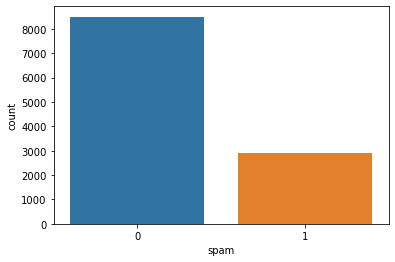

In [38]:
sns.countplot(x='spam', data=data_en)
plt.show()

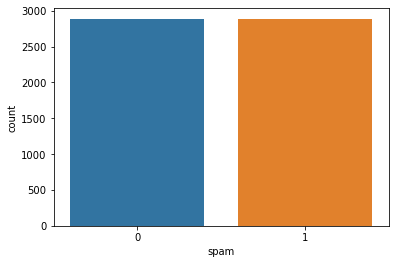

In [39]:
ham_msg = data_en[data_en.spam == 0]
spam_msg = data_en[data_en.spam == 1]
ham_msg = ham_msg.sample(n = len(spam_msg), random_state = 42)
    

balanced_data = pd.concat([ham_msg, spam_msg], ignore_index = True)

sns.countplot(x='spam', data=balanced_data)
plt.show()

In [40]:
balanced_data['text'] = balanced_data['text'].apply(lambda text: standard_data.standard_en(text))

In [41]:
balanced_data

,spam,text
0,0,july production estimate daren fyi bob forward...
1,0,wake long ago already dunno thing
2,0,takin shower yeah ill leave im done
3,0,hahahause brain dear
4,0,k ill take care
...,...,...
5771,1,youre lucky winner cocacola sweepstakes
5772,1,meet soulmate online today
5773,1,work home make big money fast
5774,1,job opportunity immediate openings available


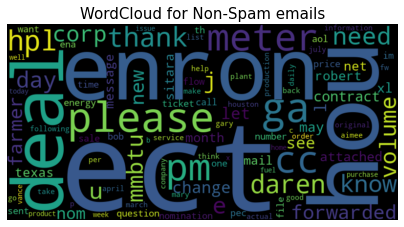

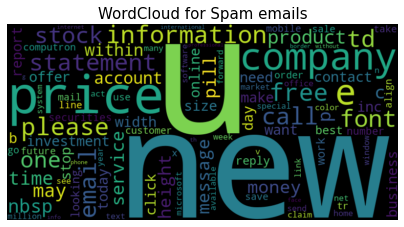

In [42]:
def plot_word_cloud(data, typ):
    email_corpus = " ".join(data['text'])
 
    plt.figure(figsize=(7, 7))
 
    wc = WordCloud(background_color='black',
                   max_words=100,
                   width=800,
                   height=400,
                   collocations=False).generate(email_corpus)
 
    plt.imshow(wc, interpolation='bilinear')
    plt.title(f'WordCloud for {typ} emails', fontsize=15)
    plt.axis('off')
    plt.show()
 
plot_word_cloud(balanced_data[balanced_data['spam'] == 0], typ='Non-Spam')
plot_word_cloud(balanced_data[balanced_data['spam'] == 1], typ='Spam')

In [43]:
train_X, test_X, train_Y, test_Y = train_test_split(balanced_data['text'],
                                                        balanced_data['spam'],
                                                        test_size = 0.2,
                                                        random_state = 42)

In [44]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_X)

In [45]:
train_sequences = tokenizer.texts_to_sequences(train_X)
test_sequences = tokenizer.texts_to_sequences(test_X)

In [46]:
max_len = 100  # maximum sequence length
train_sequences = pad_sequences(train_sequences,
                                maxlen=max_len, 
                                padding='post', 
                                truncating='post')
test_sequences = pad_sequences(test_sequences, 
                               maxlen=max_len, 
                               padding='post', 
                               truncating='post')

In [47]:
print(train_sequences)
train_sequences.shape

[[ 1832  3445 11472 ...    49   605   212]
 [11483  1599     5 ...     0     0     0]
 [ 1453  5504  1372 ...     0     0     0]
 ...
 [  529   290   860 ...     0     0     0]
 [  120  2165     7 ...     0     0     0]
 [  194   422   384 ...     0     0     0]]


(4620, 100)

In [48]:
print(test_sequences)
test_sequences.shape

[[  750   490  1271 ...  1161  2538    15]
 [   29   151    22 ...     0     0     0]
 [17579    77   109 ... 16804     5 10051]
 ...
 [    9   279   643 ... 28060     3     1]
 [   32    46   567 ...    94     3     1]
 [    8   114   325 ...     0     0     0]]


(1156, 100)

In [49]:
#2.4 Xây dựng và huấn luyện mô hình.
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Embedding(input_dim=len(tokenizer.word_index) + 1,
                                    output_dim=32, 
                                    input_length=max_len))
model.add(tf.keras.layers.LSTM(16))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
 
# Print the model summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 32)           1364864   
                                                                 
 lstm_2 (LSTM)               (None, 16)                3136      
                                                                 
 dense_4 (Dense)             (None, 32)                544       
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1368577 (5.22 MB)
Trainable params: 1368577 (5.22 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [50]:
model.compile(loss = tf.keras.losses.BinaryCrossentropy(from_logits = True),
                metrics = ['accuracy'],
                optimizer = 'adam')


es = EarlyStopping(patience=3,
                    monitor = 'val_accuracy',
                    restore_best_weights = True)

lr = ReduceLROnPlateau(patience = 2,
                        monitor = 'val_loss',
                        factor = 0.5,
                        verbose = 0)

Epoch 1/20


C:\Users\Admin\AppData\Roaming\Python\Python39\site-packages\keras\src\backend.py:5820: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


145/145 [==============================] - 13s 62ms/step - loss: 0.6434 - accuracy: 0.6043 - val_loss: 0.5899 - val_accuracy: 0.7413 - lr: 0.0010
Epoch 2/20
145/145 [==============================] - 8s 57ms/step - loss: 0.4932 - accuracy: 0.7976 - val_loss: 0.3855 - val_accuracy: 0.8789 - lr: 0.0010
Epoch 3/20
145/145 [==============================] - 8s 57ms/step - loss: 0.2998 - accuracy: 0.9087 - val_loss: 0.3855 - val_accuracy: 0.8642 - lr: 0.0010
Epoch 4/20
145/145 [==============================] - 9s 60ms/step - loss: 0.2837 - accuracy: 0.9015 - val_loss: 0.4052 - val_accuracy: 0.8547 - lr: 0.0010
Epoch 5/20
37/37 [==============================] - 1s 13ms/step - loss: 0.3855 - accuracy: 0.8789
Test Loss : 0.3855217397212982
Test Accuracy : 0.878892719745636


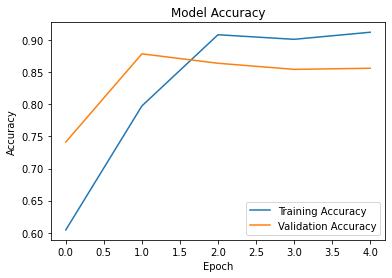

In [51]:
history = model.fit(train_sequences, train_Y,
                    validation_data=(test_sequences, test_Y),
                    epochs=20, 
                    batch_size=32,
                    callbacks = [lr, es]
                   )


test_loss, test_accuracy = model.evaluate(test_sequences, test_Y)
print('Test Loss :',test_loss)
print('Test Accuracy :',test_accuracy)

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()